In [8]:
## Required packages and example dataset
from lifelines.datasets import load_rossi
from lifelines.statistics import logrank_test
from sklearn.utils import resample
import statistics
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
import matplotlib.pyplot as plt
import numpy as np
import argparse
from pylab import rcParams      

In [9]:
def stratify_plot(df,variable,time,event,iterations):
        '''
        Given a dataframe and a desired variable, and time and event,stratify based on a log-rank test
        '''
        rcParams['figure.figsize'] = 10, 8
        minp=np.int(len(df)/5)
        for f in range(0,iterations):
            boot = resample(df, replace=True, n_samples=len(df))
            T = boot[time]
            E = boot[event]
            start = boot[variable].min()
            stop = boot[variable].max()
            step = np.abs((start-stop))/100
            cutoff_list = np.arange(start, stop, step)
            p_list = []
            num_list = []
            teststast_list = []
            resdic={}
            minvalue=[]
            i = 0
            for Cutoff in cutoff_list:
                low = (boot[variable] < Cutoff )
                high=(boot[variable] >= Cutoff )
                if len(low) >=minp and len(high)>=minp:
                    results = logrank_test(T[low], T[~low], E[low], E[~low], alpha=.99)
                    p_list.append(results.p_value)
                    num_list.append(T[low].size/low.size)
                    teststast_list.append(results.test_statistic)
                    if results.p_value==results.p_value:
                        resdic[Cutoff]=results.p_value
            minvalue.append(min(resdic, key=resdic.get))
        T=df[time]
        E=df[event]
        bestvalue=statistics.mean(minvalue)
        low = df[variable] < bestvalue
        results = logrank_test(T[low], T[~low], E[low], E[~low], alpha=.99)
        ax1 = plt.subplot(111,alpha=0.4)
        kmf.fit(T[low], event_observed=E[low], label="low {} ".format(variable))
        kmf.plot(ax=ax1,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
        kmf.fit(T[~low], event_observed=E[~low], label="high {}".format(variable))
        kmf.plot(ax=ax1,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
        lvalue=-np.log2(results.p_value)
        ax1.title.set_text("p<{}  | -log2(p)={}  | Cuttoff={}".format(round(results.p_value,5),lvalue,round(bestvalue,3)))
        plt.savefig('myimage.svg', format='svg', dpi=1200)
        

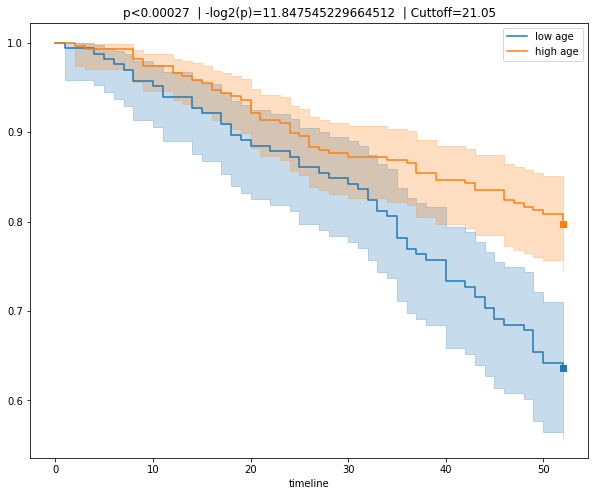

In [7]:

## Do stratification for the example data set.
#variable of stratification : age, time : week, event: arrest, 10 bootstrap iterations
rossi = load_rossi()
stratify_plot(rossi,"age","week","arrest",10)